<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/Keras_functional_model_with_multiple_inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 12th July, 2019
# Myfolder: /home/ashok/Documents/mercari_price_challenge
# Ref: https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl
# VM: lubuntu_deeplearning_II
#
#     Objectives:
#                1. Learning functional model of keras
#                2. Functional model with multiple inputs
#                3. Applying deeplearning to structured tables
#                4. Vector conversion of categorical variables
#                   as also descriptive text


In [1]:
# 1.0 Call libraries
# 1.1 Data manipulation libraries
import numpy as np
import pandas as pd

# 1.1 sklearn libraries
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# 1.2 For plotting NN model
#  conda install -c anaconda graphviz
#  conda install -c anaconda pydot
from skimage import io
import pydot

# 1.3 Keras model components
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
# 1.3.1 For text (word) to integer transformation
from tensorflow.keras.preprocessing.text import Tokenizer
# 1.3.2 For making all integer sequences of equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 1.3.3 Import backend to invoke tensorflow commands
from tensorflow.keras import backend as K

# 1.4 Plotting libraries
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
%matplotlib inline 

# 1.5 Misc
import math, time, os

In [2]:
# 2. Write a function to calculate Root Mean Squared Logarithmic Error (RMSLE)
#    Why use RMSLE?
#    Ref: https://stats.stackexchange.com/a/110610

def rmsle(y, y_pred):
    # 2.1 Check if lengths are both arrays are same
    assert len(y) == len(y_pred)
    # 2.2 Get a list of squared differences of logs
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    # 2.3 Sum up all squared differences, take a mean and then square root 
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
    
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [9]:
# 3.1 Set path to train and test data
path = "/gdrive/MyDrive/Colab_data_files/mercari/"


In [ ]:
# 3.1 Set path to train and test data
print("Loading data...")
path = "/home/ashok/.keras/datasets/mercari" 
os.chdir(path)

In [12]:
# 3.1 Read datasets
print("Loading data...")
train = pd.read_table(path+"train.tsv.zip")
test = pd.read_table(path+"test.tsv.zip")

print("---finished reading---")

Loading data...
---finished reading---


In [13]:
# 3.2 Print some information about datasets
#     In this data target is 'price'
print("---")
print(train.shape)
print(test.shape)
print("---")
print("train Memory Usage",sum(train.memory_usage())/10**6)   # In MB
print("test Memory Usage", sum(test.memory_usage())/10**6)    # In MB
print("---")
print("train Null columns",train.isnull().sum())
print("test Null columns",train.isnull().sum())

# 3.3 All columns but 'price' and shipping are categorical
train.dtypes
test.dtypes
train.columns.values

---
(1482535, 8)
(693359, 7)
---
train Memory Usage 94.882368
test Memory Usage 38.828232
---
train Null columns train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64
test Null columns train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64


array(['train_id', 'name', 'item_condition_id', 'category_name',
       'brand_name', 'price', 'shipping', 'item_description'],
      dtype=object)

In [14]:
# 4.0 Fill missing values
#     Define a function to fill missing values
#     We use pandas methods df.fillna()
#     Variables: category_name, brand_name, item_description
def fill_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

# 4.1 Fill missing values now in train and test
train = fill_missing(train)
test = fill_missing(test)

# 4.2 Check if any value is still missing
train.isnull().sum()
test.isnull().sum()

# 4.3 Look at datasets now
train.head(3)
test.head(3)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,missing,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...


In [15]:
# 4.4 Label Encode categorical values
#     Two columns: category_name and brand_name

# 4.4.1 Look at category_name data
train.category_name.values.shape        # 1D (1482535,)
test.category_name.values.shape         # 1D (693359,)

# 4.4.2 Merge category_name data into one dimensional array
catname_array = np.hstack([train.category_name.values, test.category_name.values])
# 4.4.3 Also merge brand_name data into one dimensional array
brname_array = np.hstack([train.brand_name.values, test.brand_name.values])

# 4.4.4 So final shapes:
catname_array.shape        # 1D array, (2175894,)
brname_array.shape         # 1D array, (2175894,)

# 4.4.5 And some values
catname_array[:3]
brname_array[:3]

array(['missing', 'Razer', 'Target'], dtype=object)

In [16]:
# 5.0 Label or integer encode each category and brand name

# 5.1 Instantiate object for category name transformation
le = LabelEncoder()
# 5.2 Training first
le.fit(catname_array)
# 5.3 Next transformation
train.category_name = le.transform(train.category_name.values)
test.category_name = le.transform(test.category_name.values)

# 5.4 Instantiate another object for brand name transformation
le = LabelEncoder()
# 5.5 fit and transform
le.fit(brname_array)
train.brand_name = le.transform(train.brand_name.values)
test.brand_name = le.transform(test.brand_name.values)

# 5.6 Delete objects not needed
del le, catname_array, brname_array

# 5.7 Finally look at transformed data
train.head(3)
test.head(3)


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5265,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5265,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,1000,1094,1,Brand new coach bag. Bought for [rm] at a Coac...


In [17]:
# 6. Vectorize into integers text data
#    Two columns: item_description, name

# 6.1 We assume that words in 'item_description' and 'name'
#     columns are same or iterchangeable

# 6.2 Stack two columns, item_Description and name, as arrays, end-to-end in one-dimensional array
#     We could also have stacked here: test.item_description.values, test.name.values
raw_text = np.hstack([train.item_description.values, train.name.values, test.item_description.values, test.name.values])

# 6.3 Train tokenizer
start = time.time()
tok_raw = Tokenizer()           # Create Tokenizer() object
tok_raw.fit_on_texts(raw_text)  # Train on text. No transformation as yet
end = time.time()               # Takes 2 minutes
print("...Tokenization Learning finished...", (end-start)/60, "minutes")

...Tokenization Learning finished... 1.685224715868632 minutes


In [18]:
# 7. Transform 'item_description' to integer sequences

# 7.1
print("Transforming of text to integer seq...for column, 'seq_item_desc'")
print("Transform train first to integer sequences...")
train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.values)

# 7.2
print("Transform test, next, to integer sequences...")
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.values)
print("-----")

# 7.3 Check
train.head(3)
test.head(3)

Transforming of text to integer seq...for column, 'seq_item_desc'
Transform train first to integer sequences...
Transform test, next, to integer sequences...
-----


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,seq_item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5265,1,Size 7,"[6, 64]"
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5265,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...","[439, 802, 5, 64, 34, 9040, 5191, 616, 1024, 7..."
2,2,Coach bag,1,1000,1094,1,Brand new coach bag. Bought for [rm] at a Coac...,"[16, 5, 315, 101, 201, 3, 21, 107, 4, 315, 3689]"


In [19]:
# 8.0 Transform 'name' to integer sequences

# 8.1
print("Transforming of text to integer seq...for column, 'name'")
print("Transform train first..")
train["seq_name"] = tok_raw.texts_to_sequences(train.name.values)

# 8.2
print("Transform test next to integer seq..")
test["seq_name"] = tok_raw.texts_to_sequences(test.name.values)
print("Done... print Ist few rows. Check new columns seq_name")

# 8.3
train.head(3)
test.head(3)

Transforming of text to integer seq...for column, 'name'
Transform train first..
Transform test next to integer seq..
Done... print Ist few rows. Check new columns seq_name


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,seq_item_description,seq_name
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5265,1,Size 7,"[6, 64]","[1790, 3476, 15, 5552, 51, 4, 266, 263]"
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5265,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...","[439, 802, 5, 64, 34, 9040, 5191, 616, 1024, 7...","[439, 802, 5, 64, 34, 9040, 5191, 616, 1024]"
2,2,Coach bag,1,1000,1094,1,Brand new coach bag. Bought for [rm] at a Coac...,"[16, 5, 315, 101, 201, 3, 21, 107, 4, 315, 3689]","[315, 101]"


In [20]:
# 8.4 Here are data samples of transformed columns
train.seq_name[:10]
# 8.4.1 See below how max() behaves
train.seq_name[:10].max()


[11404, 27915, 17355, 2667]

In [ ]:
# 8.5 Here are data samples of seq_item_desc
train.seq_item_description[:10]
# 8.5.1 See below how max behaves
train.seq_item_description[:10].max()


In [22]:
# 8.6 Behaviour of method: Series.max()
#     Create a sample one-column dataframe
t = pd.DataFrame({'a' : [[2,2],[2,3],[3,5], [4,0],[3,10]]})
t
# Returns that row which has first value as maximum
#  When for two cases, 1st values are equal then IInd value is seen
t.a.max()

[4, 0]

In [23]:
# 9   Analysing sequence lengths in word2vec of two columns
#    Two columns: item_description, name

# 9.1 Get maximum length integer sequences in column, seq_name
max_name_seq = np.max([
                       np.max(train.seq_name.apply(lambda x: len(x))),
                       np.max(test.seq_name.apply(lambda x: len(x)))
                       ]
                      )

# 9.2 Get maximum length of integer sequences in column, seq_item_description
max_seq_item_description = np.max([
                                   np.max(train.seq_item_description.apply(lambda x: len(x))),
                                   np.max(test.seq_item_description.apply(lambda x: len(x)))
                                   ]
                                  )

print("max name seq length"+str(max_name_seq))
print("max item desc seq length"+str(max_seq_item_description))

max name seq length17
max item desc seq length269


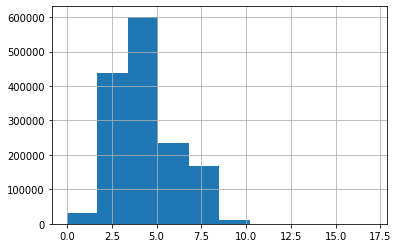

In [24]:
# 9.3 Get histogram of distribution of seq_name lengths
#     Histogram can be used to decide where to cut-off max lengths
train.seq_name.apply(lambda x: len(x)).hist()

In [ ]:
# 9.3 Get histogram of distribution of seq_item_description 
#     Histogram can be used to decide where to cut-off max lengths
train.seq_item_description.apply(lambda x: len(x)).hist()

In [25]:
# 10 EMBEDDINGS MAX VALUES
# 10.1 Based on the histograms, we select the max lengths
#      OR timesteps in RNN for two integer sequences, as:

MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75

In [26]:
# 10.2 Vocabulary sizes of all text-sequences and all label-encoded
#      caregories
#      This would be max integer value used in any column.
#      Because conversion to integer sequence starts from 1 


# 10.2.1 Columns seq_name and seq_item_description
MAX_TEXT = np.max([np.max(train.seq_name.max()),
                   np.max(test.seq_name.max()),
                   np.max(train.seq_item_description.max()),
                   np.max(test.seq_item_description.max())
                  ]
                 ) + 2

print("Maximum integer used in MAX_TEXT: ", MAX_TEXT)

# 10.2.2 Column category_name (transformed by label encoder)
MAX_CATEGORY = np.max([
                       train.category_name.max(),
                       test.category_name.max()]
                     ) + 1


print("Maximum integer used in MAX_CATEGORY: ", MAX_CATEGORY)

# 10.2.3 Column brand_name (transformed by label encoder)
MAX_BRAND =   np.max([
                      train.brand_name.max(),
                      test.brand_name.max()
                     ]
                    ) + 1

print("Maximum integer used in MAX_BRAND: ", MAX_BRAND)

# 10.2.3 Column, item_condition, already in integer format
MAX_CONDITION = np.max([
                        train.item_condition_id.max(),
                        test.item_condition_id.max()
                        ]
                       ) + 1

print("Maximum integer used in MAX_CONDITION: ", MAX_CONDITION)

Maximum integer used in MAX_TEXT:  321998
Maximum integer used in MAX_CATEGORY:  1311
Maximum integer used in MAX_BRAND:  5290
Maximum integer used in MAX_CONDITION:  6


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc93c90fb90>]],
      dtype=object)

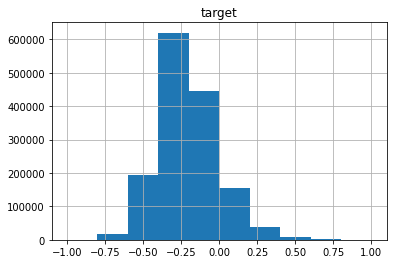

In [27]:
# 11 Scale target variable, 'price': 
#     First take log and then scale log

# 11.1 First take a log of target. Why?
#      Make target values symmetric
train["target"] = np.log( train.price + 1)   # Add 1 to escape from -ve infinity

# 11.2 Then scale log values using min-max scaler between -1 and 1
#      Why?
#      Scaling between (-1,1) is helpful in NN modeling
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1,1))

# 11.3 Display histogram of transformed target
#      It is quite symmetric
pd.DataFrame(train.target).hist()

In [28]:
# 12 Create an arbitrary column. Why?
#    We want two numerical columns for better demonstration of our
#    proposed architecture. Otherwise, this column is NOT at all needed

# 12.1 Add some small random values to shipping column and create a new column
train['ship_rand'] = train.shipping + np.random.random(size = train.shipping[0])
train.head()

# 12.2
test['ship_rand'] = test.shipping + np.random.random(size = test.shipping[0])
test.head()

# 12.3
train.shape    # (1482535, 12)
test.shape     # (693359, 10)   Missing 'price' and its transformed column 'target'


(693359, 10)

In [29]:
# 13. Split into train and test
#     Note that we do not have 'y' here. 
#     Why? Because 'price' is a continuous variable

# 13.1 Just 'train' will be split into two parts
#      This is permissible in sklearn syntax
dtrain, dvalid = train_test_split(train,
                                  random_state=123,
                                  train_size=0.99    # 99% vs 1%
                                 )

print(dtrain.shape)     # (1467709, 12)
print(dvalid.shape)     # (14826, 12) 1% of above

(1467709, 12)
(14826, 12)


In [30]:
# 13.2 Define a function that creates a dictionary of array values 
#      to help to feed data into keras
#      All columns but the last 'num_vars' are categorical
#      WE have SIX columns or column-sets here
def get_keras_data(dataset):
    X = {   
        'name':           pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),                             # 1
        'item_desc':      pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),            # 2
        'brand_name':     np.array(dataset.brand_name),                                                     # 3
        'category_name':  np.array(dataset.category_name),                                                  # 4
        'item_condition': np.array(dataset.item_condition_id),                                              # 5
        'num_vars':       np.array(dataset[["shipping", "ship_rand"]])    # Two numeric columns here        # 6
    }
    return X

# 13.3 Get these datasets now
X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [31]:
# 13.4 Just check shapes. We need these below
X_train["name"][:4]
X_train["item_desc"][:4]
X_train["num_vars"][:4]

# 13.5
X_train["name"].shape[1]           # 10
X_train["item_desc"].shape[1]      # 75
X_train["num_vars"].shape[1]       # 2


2

## Convert categorical columns to word-vectors
### A
Consider following sentences:<br><p>
1. mango is sweet<br>
2. apple is sweet<br>
3. mouse moves pointer<br>
4. iphone mobile is used for communication<br>

An embedding layer will convert word to vectors to discover relationship among words. Or, one can say that conversion of a word to vectors, facilitates finding association between context words. Examples are: <br>

(mango, sweet), (apple, sweet), (mouse,pointer), (iphone,mobile) <br>

### B
Now, consider the following table with three categorical columns: <br>

| x1   |   x2    |   x3    |
|------|---------|---------|  
|mango |  tree   |  sweet  |
|apple |  tree   |  sweet  |
|mouse | pointer |  moves  |
|iphone| mobile  |communication|

Conversion of categorical values to word-vectors helps discover better association between mango and sweet OR mango and tree OR mouse and pointer etc than by simply label encoding them and applying machine learning algo to discover patterns.

In [32]:
# 14.1 Sizes of categorical values AND word to vectors
#      Sizes?
word2vec_size = 50
cat2vec_size = 10
cond2vec_size = 5

# 14.2 Define callback function for earlystopping and storing weights
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

# 14.3 Forget it in first reading. Another loss function
#      Any functions used in the model must use tensors
#      and not numpy arrays. Of course, dataset can be numpy
def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

# 14.4 Our model
def get_model():
    
    # 14.1 Level of dropouts: 10%
    dr_r = 0.1   
    
    # 14.2 SIX Inputs. At each input specify number of input-features 
    name =            Input(shape=[X_train["name"].shape[1]],      name="name")
    item_desc =       Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name =      Input(shape=[1],                             name="brand_name")  # Just 1 feature.Hence shape=[1]
    category_name =   Input(shape=[1],                             name="category_name") # Just 1 feature.Hence shape=[1]
    item_condition =  Input(shape=[1],                             name="item_condition") # Just 1 feature. Hence shape = [1]
    num_vars =        Input(shape=[X_train["num_vars"].shape[1]],  name="num_vars")
    
    # 14.3 FIVE Embeddings layers.  Embedding vectors of first FIVE of the above
    
    # 14.3.1 Output of following two also go in RNN.
    #        RNN output needs no flattening as this output is received
    #        AFTER all timesteps have been fed into RNN
    emb_name =           Embedding(MAX_TEXT,      word2vec_size  )(name)               
    emb_item_desc =      Embedding(MAX_TEXT,      word2vec_size  )(item_desc)
    
    # 14.3.2 Output of following three go directly into Dense layer after flattening
    #        These need to be flattened as for every timestep there is a vector
    emb_brand_name =     Embedding(MAX_BRAND,     cat2vec_size  )(brand_name)
    emb_category_name =  Embedding(MAX_CATEGORY,  cat2vec_size  )(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, cond2vec_size )(item_condition)
    
    # 14.4 TWO RNN layers. Both these are independent of each other. 
    rnn_layer2 = GRU(8) (emb_name)          # Output of GRU is a vector of size 8
    rnn_layer1 = GRU(16) (emb_item_desc)    # Output of GRU is a vector of size 16
    
    # 15. Concatenate all layer-branches 
    main_l = concatenate([
                          Flatten() (emb_brand_name),
                          Flatten() (emb_category_name),
                          Flatten() (emb_item_condition),
                          rnn_layer1,
                          rnn_layer2,
                          num_vars          # Feed numerical variables as they are
                          ]
                         )
    
    # 15.1 Add classification layer
    main_l = Dense(128) (main_l)
    main_l = Dropout(dr_r)(main_l)
    main_l = Dense(64) (main_l)
    main_l = Dropout(dr_r) (main_l)
    
    # 15.2 Output neuron
    output = Dense(1, activation="linear") (main_l)
    
    # 15.3 Formulate Model now
    model = Model(
                  inputs= [name, item_desc, brand_name,category_name, item_condition, num_vars],
                  outputs= output
                 )
    # 15.4
    model.compile(loss="mse",
                  optimizer="adam",
                  metrics=["mae", rmsle_cust]    # Note two metrics here. First reading confine to 'mae' only
                 )
    return model


# 16 Formulate model and show summary    
model = get_model()
model.summary()
    


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          [(None, 75)]         0                                            
______________________________________________________________________________________________

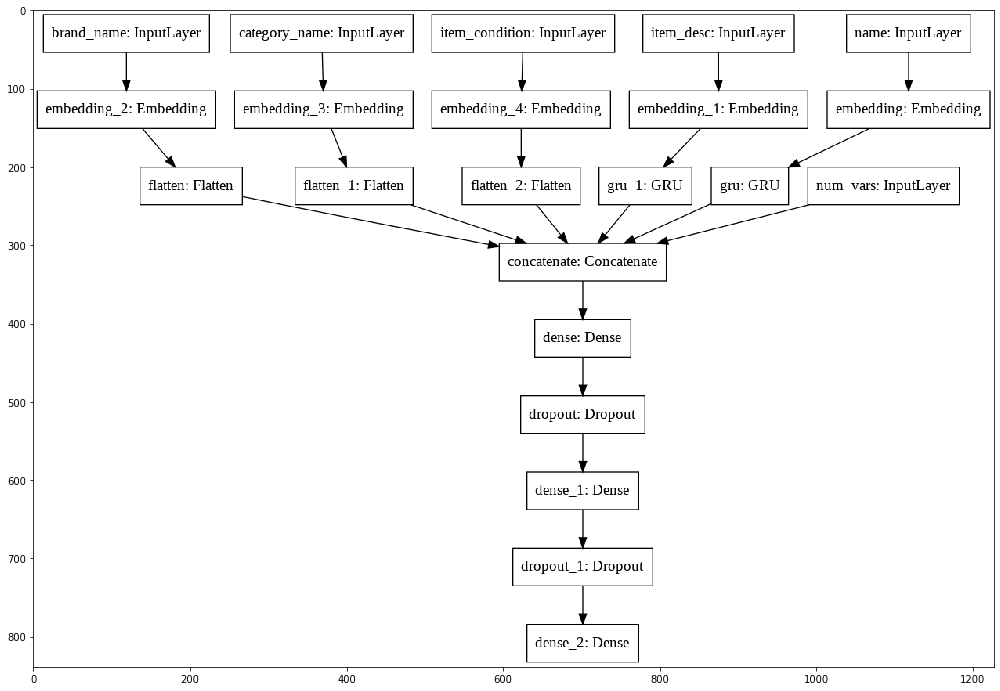

In [33]:
# 16.1 Plot the model architecture
#      We need graphviz and pydot to be installed
plt.figure(figsize = (14,14))
plot_model(model, to_file = "model.png")
io.imshow("model.png")




In [ ]:
# 17. Training the model
BATCH_SIZE = 20000
epochs = 5
model = get_model()

# 17.1
start = time.time()
history= model.fit(X_train,
                   dtrain.target,
                   epochs=epochs,
                   batch_size=BATCH_SIZE,
                   validation_data=(X_valid, dvalid.target),
                   verbose=1
                  )

end = time.time()
print((end-start)/60)    # Five epochs take 15 minutes

In [35]:
# 18 Evaluate model using validation data
val_preds = model.predict(X_valid)
# 18.1 Undo transformation by MinMaxScaler
val_preds = target_scaler.inverse_transform(val_preds)  
# 18.2 Undo logs
val_preds = np.exp(val_preds) - 1   # It should be -1. Original code has +1
val_preds[:10]     # (10,1)
val_preds[:10, 0]  # Convert to 1D
y_pred = val_preds[:,0]

# 19. Mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_true[:10]

# 19.1
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.4693206202824715


In [36]:
########### I am done #############
# Optional

# 20. Create Predictions on test data
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

# 20.1
submission = test[["test_id"]]
submission["price"] = preds

InvalidArgumentError: ignored

In [ ]:
# 20.2 Should you want to submit on 
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()


This was just an example how nn can solve this problems. Potencial improvements of the kernel:
    - Increase the embeddings factors
    - Decrease the batch size
    - Add Batch Normalization
    - Try LSTM, Bidirectional RNN, stack RNN
    - Try with more dense layers or more rnn outputs
    -  etc. Or even try a new architecture!